## Import

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [148]:
import tensorflow as tf

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import save_model, load_model

from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.layers import LSTM, GRU, Bidirectional, TimeDistributed, Lambda, Bidirectional
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam



In [4]:
def create_dataset():
    X=[]
    y=[]

    folders = ['backhand', 'forehand', 'service', 'smash']
    for folder in folders:
        base_path = f'../keypoints/{folder}/'
        for csv_path in os.listdir(base_path):
            data = pd.read_csv(base_path + csv_path)
            
            features = data.loc[:, data.columns != 'class']

            X.append(features.to_numpy())
            y.append(data["class"].iloc[0])

    X = np.stack(X, axis=0)
    X = np.array(X)
    y = np.array(y)

    return X, y

In [128]:
# 데이터 좌우 대칭 -> x 값만 변화, y값 변화 없음
def revert_datasets(df):
    revert_data = df.copy()
    
    for feature in df.columns:
        if feature[-2:] == '_x':
            revert_data[feature] = 1 - df[feature]
    return revert_data

## 6 Classes Dataset

In [58]:
# 0 - 71: backhand2hands -> backhand
# 72 - 124: backhand
# 125 - 190: backhand_slice -> backhand
# 191 - 247: backhand_volley
# 248 - 306: forehand_flat -> forehand
# 307 - 355: forehand_openstands -> forehand
# 356 - 413: forehand_slice -> forehand
# 414 - 470: forehand_volley
# 471 - 539: flat_service -> service
# 540 - 600: kick_service -> service
# 601 - 650: slice_service -> service
# 651 - 704: smash

In [160]:
# 'backhand': 0, 'forehand': 1, 'service': 2, 'smash': 3, 'backhand_volley': 4, 'forehand_volley' : 5

sequence_length = 50

def create_dataset_6cls():
    X=[]
    y=[]

    folders = ['backhand', 'forehand', 'service', 'smash']
    for folder in folders:
        base_path = f'../keypoints/{folder}/'
        for csv_path in os.listdir(base_path):
            df = pd.read_csv(base_path + csv_path)
            df = df.drop(df.columns[2:10], axis=1) # ear와 eye에 관련된 column 제거

            # 'backhand_volley'
            if folder == 'backhand':
                if int(csv_path[9:-4]) >= 191 and int(csv_path[9:-4]) <= 247:
                    df.loc[df['class'] == 0, 'class'] = 4
            
            # 'forehand_volley'
            if folder == 'forehand':
                if int(csv_path[9:-4]) >= 414 and int(csv_path[9:-4]) <= 470:
                    df.loc[df['class'] == 1, 'class'] = 5

            # 60개씩 끊어서 저장
            num_rows = df.shape[0]
            num_batches = num_rows // sequence_length
            
            for i in range(num_batches):
                start_idx = i * sequence_length
                end_idx = (i + 1) * sequence_length

                data = df.iloc[start_idx : end_idx, :].reset_index(drop=True)

                features = data.loc[:, data.columns != 'class']
                X.append(features.to_numpy())
                y.append(data["class"].iloc[0])
                
    X = np.stack(X, axis=0)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [161]:
X, y = create_dataset_6cls()

In [162]:
print(X.shape)
print(y.shape)

(682, 50, 26)
(682,)


In [163]:
# Split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=123, stratify=y)

# One-hot Encoding
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

num_classes = 6
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(477, 50, 26)
(477, 6)
(205, 50, 26)
(205, 6)


## 4 Classes dataset

In [87]:
sequence_length = 17

def create_revert_dataset():
    X=[]
    y=[]

    folders = ['backhand', 'forehand', 'service', 'smash']
    for folder in folders:
        base_path = f'../keypoints/{folder}/'
        for csv_path in os.listdir(base_path):
            df = pd.read_csv(base_path + csv_path)
            df = df.drop(df.columns[2:10], axis=1) # ear와 eye에 관련된 column 제거

            # 60개씩 끊어서 저장
            num_rows = df.shape[0]
            num_batches = num_rows // sequence_length
            
            for i in range(num_batches):
                start_idx = i * sequence_length
                end_idx = (i + 1) * sequence_length

                data = df.iloc[start_idx : end_idx, :].reset_index(drop=True)

                # 데이터 변환
                # revert_data = revert_datasets(df)

                # X.append(revert_data.values[1:])
                # y.append(revert_data['class'].values[0])

                features = data.loc[:, data.columns != 'class']
                X.append(features.to_numpy())
                y.append(data["class"].iloc[0])
                
    X = np.stack(X, axis=0)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [88]:
X, y = create_revert_dataset()

In [89]:
print(X.shape)
print(y.shape)
print(y)

(682, 50, 26)
(682,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [79]:
# Split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True)

In [80]:
# One-hot Encoding
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

num_classes = 4
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

IndexError: index 4 is out of bounds for axis 1 with size 4

## GRU

In [48]:
# Model 정의
model = Sequential([
    GRU(48, dropout=0.1, input_shape=(sequence_length, 26)),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 48)                10944     
                                                                 
 dropout_3 (Dropout)         (None, 48)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 392       
                                                                 
 dense_7 (Dense)             (None, 4)                 36        
                                                                 
Total params: 11,372
Trainable params: 11,372
Non-trainable params: 0
_________________________________________________________________


In [21]:
# checkpoint = ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=0, save_best_only=True, mode='auto')
checkpoint = ModelCheckpoint('../models/model.h5', verbose=0, save_best_only=True)
# scheduler = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, mode='auto')

batch_size = 32
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=300,
    batch_size=batch_size,
    callbacks=[checkpoint]
)

# 모델 저장
path = '../models/model7.h5'
save_model(model, path)

Epoch 1/300
12/12 [==============================] - 2s 55ms/step - loss: 1.4207 - acc: 0.2781 - val_loss: 1.3788 - val_acc: 0.2811
Epoch 2/300
12/12 [==============================] - 0s 7ms/step - loss: 1.3591 - acc: 0.2888 - val_loss: 1.3853 - val_acc: 0.2811
Epoch 3/300
12/12 [==============================] - 0s 9ms/step - loss: 1.3368 - acc: 0.3102 - val_loss: 1.3517 - val_acc: 0.2811
Epoch 4/300
12/12 [==============================] - 0s 10ms/step - loss: 1.3254 - acc: 0.3262 - val_loss: 1.3281 - val_acc: 0.2811
Epoch 5/300
12/12 [==============================] - 0s 7ms/step - loss: 1.3171 - acc: 0.3182 - val_loss: 1.3296 - val_acc: 0.2811
Epoch 6/300
12/12 [==============================] - 0s 9ms/step - loss: 1.3007 - acc: 0.3369 - val_loss: 1.3137 - val_acc: 0.2811
Epoch 7/300
12/12 [==============================] - 0s 9ms/step - loss: 1.2979 - acc: 0.3128 - val_loss: 1.3099 - val_acc: 0.2811
Epoch 8/300
12/12 [==============================] - 0s 9ms/step - loss: 1.2674 -

KeyboardInterrupt: 

In [ ]:
# 모델 불러오기
loaded_model = load_model('../models/model1.h5')

## LSTM

In [164]:
units = 128
model = Sequential([
    Dropout(0.1, input_shape=(sequence_length, 26)),
    Bidirectional(LSTM(256, return_sequences=True, dropout=0.5), merge_mode='concat'),
    TimeDistributed(Dropout(0.1)),
    TimeDistributed(Dense(128, activation='relu')),
    TimeDistributed(Dense(6, activation='softmax')),
    Lambda(function=lambda x: K.mean(x, axis=1))
])

In [ ]:
model = Sequential([
    LSTM(256, dropout=0.1, input_shape=(sequence_length, 26), return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(32, dropout=0.1, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    # LSTM(64, dropout=0.1, return_sequences=False),
    # BatchNormalization(),
    # Dropout(0.3),
    Dense(32, activation='relu'), # , kernel_regularizer=l2(0.001)
    Dense(6, activation='softmax')
])

In [165]:
model.compile(optimizer=Adam(1e-5, decay=1e-6), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_37 (Dropout)        (None, 50, 26)            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 50, 512)          579584    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 50, 512)          0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 50, 128)          65664     
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 50, 6)            774       
 stributed)                                          

In [166]:
checkpoint = ModelCheckpoint('../models/model11.h5', verbose=1, save_best_only=True, period=1, monitor='val_categorical_accuracy')
# scheduler = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, mode='auto')

batch_size = 16

history = model.fit(
    X_train,
    y_train,
    epochs=300,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint]
)

Epoch 1/300
26/30 [=========================>....] - ETA: 0s - loss: 1.7746 - categorical_accuracy: 0.2716
Epoch 1: val_categorical_accuracy improved from -inf to 0.27317, saving model to ../models\model11.h5
30/30 [==============================] - 4s 36ms/step - loss: 1.7703 - categorical_accuracy: 0.2746 - val_loss: 1.7508 - val_categorical_accuracy: 0.2732
Epoch 2/300
26/30 [=========================>....] - ETA: 0s - loss: 1.7434 - categorical_accuracy: 0.2716
Epoch 2: val_categorical_accuracy did not improve from 0.27317
30/30 [==============================] - 0s 13ms/step - loss: 1.7419 - categorical_accuracy: 0.2725 - val_loss: 1.7195 - val_categorical_accuracy: 0.2732
Epoch 3/300
27/30 [==========================>...] - ETA: 0s - loss: 1.7202 - categorical_accuracy: 0.2755
Epoch 3: val_categorical_accuracy did not improve from 0.27317
30/30 [==============================] - 0s 13ms/step - loss: 1.7172 - categorical_accuracy: 0.2746 - val_loss: 1.6971 - val_categorical_accura

KeyboardInterrupt: 

In [116]:
loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Accuracy on validation dataset = {accuracy}")

model.load_weights('../models/model11.h5')

loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Accuracy on validation dataset = {accuracy}")

7/7 [==============================] - 0s 12ms/step - loss: 0.6270 - acc: 0.7561
Accuracy on validation dataset = 0.7560975551605225
7/7 [==============================] - 0s 14ms/step - loss: 0.6000 - acc: 0.7707
Accuracy on validation dataset = 0.7707316875457764


In [55]:
model.save('../models/model_2lstm_seq50.h5')

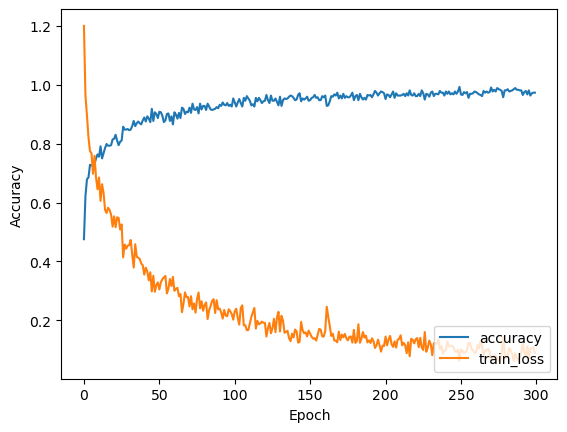

In [56]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

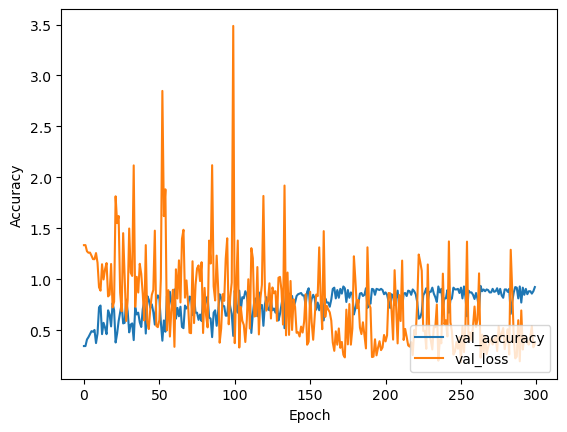

In [57]:
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')